# Problem 2 : Game of Tic-Tac-Toe

Consider a 3×3 Tic-Tac-Toe game. The aim of this problem is to implement a Tic-Tac-Toe agent
using Q-learning. This is a two player game in which the opponent is part of the environment.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Tic-tac-toe Class

In [39]:
class tic_tac_toe:    
    def __init__(self):
        
        self.agent = 'X'      
        self.opponent = 'O'
        self.board = [[' ']*3 for _ in range(3)]
        self.first_move_decider = random.randint(0, 1)    # 0 -> Agent moves first,  1 = Opponent starts
        if self.first_move_decider == 0:
            self.current_player = self.agent        # 'X'
        else:
            self.current_player = self.opponent     # 'O'
            
        self.occupied_squares = []
        
        
    def reset(self):
        self.board = [[' ']*3 for _ in range(3)]
        self.first_move_decider = random.randint(0, 1)    # 0 -> Agent moves first,  1 = Opponent starts
        if self.first_move_decider == 0:
            self.current_player = self.agent        # 'X'
        else:
            self.current_player = self.opponent     # 'O'
        
        self.occupied_squares = []                  # Reinitialise the occupied squares to be empty
       
    
    def act(self, row_move, col_move, check_blocking = 0):
        
        """ Checks if the move suggested by the agent is valid and 
                    place the 'X' in the appropriate board position.
                                                                      """
        if check_blocking == 0:
            if self.is_valid_move(row_move, col_move):
                # Place the 'X' at the right position
                if self.current_player == 'X':   # agent
                    self.board[row_move][col_move] = 'X'
                    self.current_player = 'O'
                else:
                    self.board[row_move][col_move] = 'O'
                    self.current_player = 'X'   

            else:
                print("Move is invalid !")

            self.occupied_squares.append([row_move, col_move])   # Update the occupied squares
        
        
        elif check_blocking == 1:  # Check if the agent placing 'X' at row_move, col_move results in winning 
            if self.is_valid_move(row_move, col_move):
                self.board[row_move][col_move] = 'X'            # Place the 'X' at the right position   
            else:
                print("Move is invalid !")
               
            
        else:  # Check if the opponent placing 'O' at row_move, col_move results in winning 
            if self.is_valid_move(row_move, col_move):
                self.board[row_move][col_move] = 'O'            # Place the 'O' at the right position   
            else:
                print("Move is invalid !")
                
    
    def is_valid_move(self, row_move, col_move):
        if row_move >= 0 and row_move <=2:
            if col_move >= 0 and col_move <= 2:
                if [row_move, col_move] not in self.occupied_squares:
                    return True
            
        return False

    
    def is_winner(self, player):       # pass either 'X' or 'O'  as argument
        win_move = [player, player, player]                # Define the win move e.g [['X', 'X', 'X']]
        
        for row in self.board:                               # ROW
            if row == win_move:
                return True
        
        for i in range(3):                                  # COLUMN
            col = [self.board[row][i] for row in range(3)]
            if col == win_move:
                return True
            
        # Any of the diagonal
        if self.board[0][0] == player and self.board[1][1] == player and self.board[2][2] == player:
            return True
        elif self.board[2][0] == player and self.board[1][1] == player and self.board[0][2] == player:
            return True
        
        return False
    
    
    def is_draw(self):
        if self.is_winner('X') or self.is_winner('O'):    # even if all the cells are non-empty, it may be a WIN/LOSE
            return False
        
        return all(cell != ' ' for row in self.board for cell in row)

    def is_game_over(self):
        return self.is_winner('X') or self.is_winner('O') or self.is_draw()
    

    def print_tic_tac_toe(self):
        # Prints the current board position
        print("-" * 9)
        for i, row in enumerate(self.board):
            print(" | ".join(row))
            # if i != len(self.board) - 1:
            print("-" * 9)
        print("\n")
    

## Agents 
- Random Agent : picks a square among all available empty squares in a (uniform) random fashion
- Safe Agent : checks for winning move for itself, if not tries to block the agent's potential winning move. Else, random fashion

In [3]:
class Random_agent:   # Random opponent
    def __init__(self):
        pass
    
    def choose_move(self, env):
        occupied_squares = np.array(env.occupied_squares)

        # Generate all possible combinations of (i, j)
        all_squares = np.array([[i, j] for i in range(3) for j in range(3)])

        # Calculate available_squares by filtering out occupied_squares
        available_squares = [square.tolist() for square in all_squares if list(square) not in occupied_squares.tolist()]

        # Choose a random available square
        return tuple(random.choice(available_squares))   # RETURNS IN THE FORM [row_no, col_no]
    
    
class Safe_agent:
    def __init__(self):
        pass
    
    def choose_move(self, env):
        # Check for a winning move
        for i in range(3):
            for j in range(3):
                potential_move = [i, j]
                if potential_move not in env.occupied_squares:   # if unoccupied, check if it results in winning move
                    env.act(i, j, 2)  
                    if env.is_winner('O'):                       # if the safe_agent/opponent makes the move and wins
                        env.board[i][j] = ' '
                        return (i, j)
                    env.board[i][j] = ' '
    
                    
        # Check if there's a blocking move
        for i in range(3):
            for j in range(3):
                one_step_forward_potential_move_by_agent = [i, j]
                if one_step_forward_potential_move_by_agent not in env.occupied_squares:
                    env.act(i, j, 1)
                    if env.is_winner('X'):   # if the agent wins with this move, it is a potential blocking move 
                        env.board[i][j] = ' '
                        return (i, j)
                    env.board[i][j] = ' '
        
        # If no WINNING or Blocking move,
        return Random_agent().choose_move(env)

## The Q-learning Agent

In [4]:
class Q_learning_agent:
    def __init__(self, epsilon=0.1, epsilon_decay=1.0, alpha=0.5, gamma=0.9):
        self.q_table = {}                         # {state_key : action1: value1 , action2: ]}
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay  # Add epsilon_decay parameter
        self.alpha = alpha
        self.gamma = gamma
        self.n_episodes = 0
        
    def state_2_key(self, board):
        state_key = tuple(map(tuple, board))
        return state_key                         # Convert the board to a hashable tuple

    
    def choose_move(self, env, assess = False):
        state_key = self.state_2_key(env.board)
        available_squares = [(i, j) for i in range(3) for j in range(3) if env.is_valid_move(i, j)]        
        
        if assess:  # if assess then no exploration
            if state_key not in self.q_table: # If not already, Initialise the Q-table
                self.q_table[state_key] = {action: 0.0 for action in available_squares}
                
            max_value = self.q_table[state_key][available_squares[0]]
            max_index = 0
            for i in range(len(available_squares)):
                if max_value < self.q_table[state_key][available_squares[i]]:
                    max_index = i
                    max_value = self.q_table[state_key][available_squares[i]]
                
                
            best_action = available_squares[max_index] # 
            return best_action
        

        # If not on assess mode, Exploration should be there
        if random.uniform(0, 1) < self.epsilon:  
            return random.choice(available_squares)
        
        else: 
            if state_key not in self.q_table: # Initialise the Q-table
                self.q_table[state_key] = {action: 0.0 for action in available_squares}

            max_value = self.q_table[state_key][available_squares[0]]
            max_index = 0
            for i in range(len(available_squares)):
                if max_value < self.q_table[state_key][available_squares[i]]:
                    max_index = i
                    max_value = self.q_table[state_key][available_squares[i]]
                
                
            best_action = available_squares[max_index] # 
            return best_action
     
        
    def q_table_update(self, state_key, action, reward, next_state_key):
        available_squares = [(i, j) for i in range(3) for j in range(3) if env.is_valid_move(i, j)] 
        all_squares = [(i, j) for i in range(3) for j in range(3)]
        
        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0.0 for action in all_squares}
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {action: 0.0 for action in all_squares}
        
        old_q_value = self.q_table[state_key][action]
        max_among_next = max(self.q_table[next_state_key].values(), default = 0)            # to handle the terminal case when agent loses
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_among_next - old_q_value)   # UPDATE RULE       
        self.q_table[state_key][action] = new_q_value


    def decay_epsilon(self):
        self.n_episodes += 1
        self.epsilon *= self.epsilon_decay
    
    

### Helper fucntions to :
- Play an episode
- Test the agent

In [5]:
def play_an_episode(env, agent, opponent):
    env.reset()
    done = False
    count = 0
    while not done:
        if env.current_player == 'X':
            state_key1 = agent.state_2_key(env.board)
            row1, col1 = agent.choose_move(env, assess = False)
            env.act(row1, col1)                               # act will automatically fill 'X' or 'O' accordingly
            next_state_key1 = agent.state_2_key(env.board)

        else:
            state_key2 = agent.state_2_key(env.board)
            row2, col2 = opponent.choose_move(env)
            env.act(row2, col2)                               # act will automatically fill 'X' or 'O' accordingly
            next_state_key2 = agent.state_2_key(env.board)       
        
        count += 1
        done = env.is_game_over()
        if not done:
            if env.current_player == 'X' and count > 1:   # 'O'  was last
                agent.q_table_update(state_key1, (row1, col1), 0.0, next_state_key2)

    agent.decay_epsilon()
    if env.is_winner('X'):                                           # if agent wins, the last step was agent's 
        agent.q_table_update(state_key1, (row1, col1), 1, next_state_key1)
    elif env.is_winner('O'):                                         # if agent loses, last step was that of opponent
        agent.q_table_update(state_key1, (row1, col1), -1, next_state_key2)
    else:                                                            # if its a draw, determine who did the last step
        if env.current_player == 'X':   # 'O'  was last
            agent.q_table_update(state_key1, (row1, col1), 0.5, next_state_key2)
        else:
            agent.q_table_update(state_key1, (row1, col1), 0.5, next_state_key1)
    
    
    
    
def test_agent(env, agent, opponent, num_games, assess = False):
    n_wins, n_draws, n_losses = 0, 0, 0
    
    for game in range(num_games):
        env.reset()
        done = False
        while not done:
            if env.current_player == 'X':
                row, col = agent.choose_move(env, assess)
            else:
                row, col = opponent.choose_move(env)
            env.act(row, col)
            done = env.is_game_over()
        
        if env.is_winner('X'):
            n_wins += 1
        elif env.is_winner('O'):
            n_losses += 1
        else:
            n_draws += 1
    
    return n_wins, n_draws, n_losses



def test_agent_random(env, agent, safe_opponent, random_opponent, num_games, assess = False):
    n_wins, n_draws, n_losses = 0, 0, 0
    
    for game in range(num_games):
        env.reset()
        if(np.random.rand() > 0.5):
            opponent = safe_opponent
        else:
            opponent = random_opponent
        done = False
        while not done:
            if env.current_player == 'X':
                row, col = agent.choose_move(env, assess)
            else:
                row, col = opponent.choose_move(env)
            env.act(row, col)
            done = env.is_game_over()
        
        if env.is_winner('X'):
            n_wins += 1
        elif env.is_winner('O'):
            n_losses += 1
        else:
            n_draws += 1
    
    return n_wins, n_draws, n_losses
    

## Training and Testing 

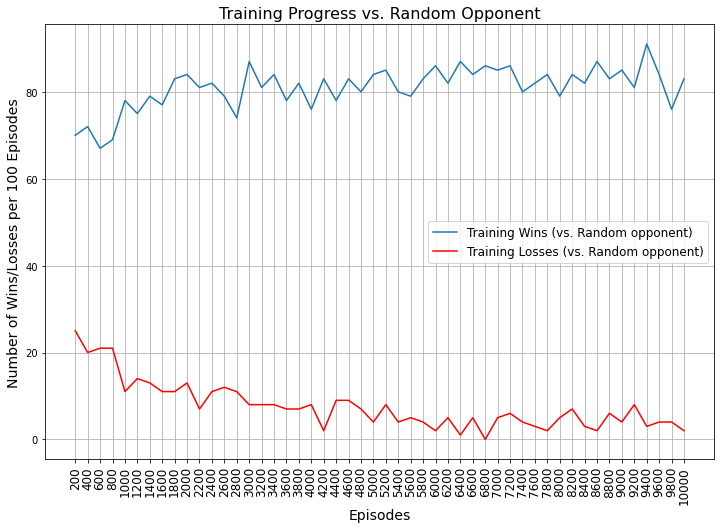

In [6]:
# TRAINING AND PLOTS - 1
env = tic_tac_toe()
Q_agent_1 = Q_learning_agent()
random_opponent = Random_agent()
training_wins_per_100_games = []
training_losses_per_100_games = []

for episode in range(1, 10001):           # Only during training, play_an_episode is called
    play_an_episode(env, Q_agent_1, random_opponent)
    
    if episode % 200 == 0:
        n_wins, n_draws, n_losses = test_agent(env, Q_agent_1, random_opponent, 100, True)
        training_wins_per_100_games.append(n_wins)
        training_losses_per_100_games.append(n_losses)
      
    
plt.figure(figsize=(12, 8))
plt.plot(range(200, 10001, 200), training_wins_per_100_games, label='Training Wins (vs. Random opponent)')
plt.plot(range(200, 10001, 200), training_losses_per_100_games, label='Training Losses (vs. Random opponent)', color='red')
custom_ticks = range(200, 10001, 200)
plt.xticks(custom_ticks, rotation='vertical', fontsize=12)  
plt.xlabel('Episodes', fontsize=14)  
plt.ylabel('Number of Wins/Losses per 100 Episodes', fontsize=14)  
plt.legend(fontsize=12)  
plt.title('Training Progress vs. Random Opponent', fontsize=16)  
plt.grid(True)


sns.set_palette("viridis") 

plt.show()

In [7]:
# TESTING - 1
print("For the Q-AGENT trained against RANDOM opponent :- \n")
random_opponent = Random_agent()
safe_opponent = Safe_agent()


total_wins_random, total_draws_random,  total_losses_random = test_agent(env, Q_agent_1, random_opponent, 1000, True)

total_wins_safe, total_draws_safe, total_losses_safe  = test_agent(env, Q_agent_1, safe_opponent, 1000, True)


print("Results vs. Random Opponent:")
print(f"Wins: {total_wins_random}, Draws: {total_draws_random}, Losses: {total_losses_random} \n")

print("Results vs. Safe Opponent:")
print(f"Wins: {total_wins_safe}, Draws: {total_draws_safe}, Losses: {total_losses_safe}")

For the Q-AGENT trained against RANDOM opponent :- 

Results vs. Random Opponent:
Wins: 875, Draws: 107, Losses: 18 

Results vs. Safe Opponent:
Wins: 448, Draws: 432, Losses: 120


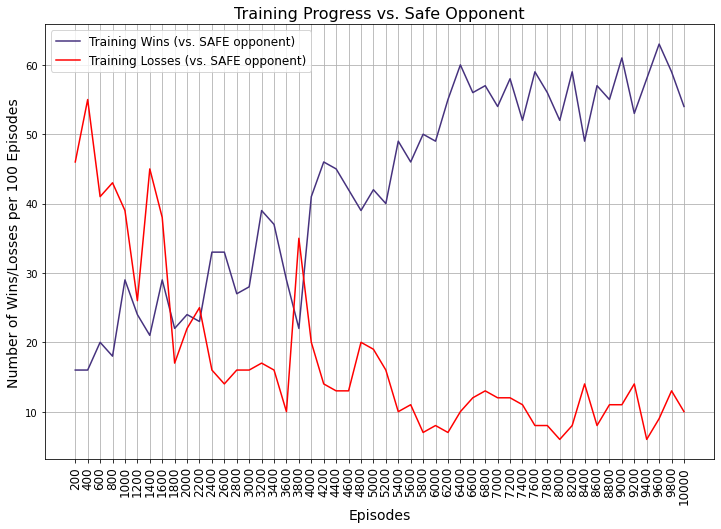

In [8]:
# TRAINING AND PLOTS - 2
env = tic_tac_toe()
Q_agent_2 = Q_learning_agent()
safe_opponent = Safe_agent()
training_wins_per_100_games = []
training_losses_per_100_games = []


for episode in range(1, 10001):
    play_an_episode(env, Q_agent_2, safe_opponent)
    
    if episode % 200 == 0:
        n_wins, n_draws, n_losses = test_agent(env, Q_agent_2, safe_opponent, 100, True)
        training_wins_per_100_games.append(n_wins)
        training_losses_per_100_games.append(n_losses)
        
      
    
plt.figure(figsize=(12, 8))
plt.plot(range(200, 10001, 200), training_wins_per_100_games, label='Training Wins (vs. SAFE opponent)')
plt.plot(range(200, 10001, 200), training_losses_per_100_games, label='Training Losses (vs. SAFE opponent)', color='red')
custom_ticks = range(200, 10001, 200)
plt.xticks(custom_ticks, rotation='vertical', fontsize=12)  
plt.xlabel('Episodes', fontsize=14)  
plt.ylabel('Number of Wins/Losses per 100 Episodes', fontsize=14)  
plt.legend(fontsize=12)  
plt.title('Training Progress vs. Safe Opponent', fontsize=16)  
plt.grid(True)


sns.set_palette("viridis") 

plt.show()

In [9]:
# TESTING - 2
print("For the Q-AGENT trained against SAFE opponent :- \n")
random_opponent = Random_agent()
safe_opponent = Safe_agent()


total_wins_random, total_draws_random,  total_losses_random = test_agent(env, Q_agent_2, random_opponent, 1000, True)

total_wins_safe, total_draws_safe, total_losses_safe  = test_agent(env, Q_agent_2, safe_opponent, 1000, True)


print("Results vs. Random Opponent:")
print(f"Wins: {total_wins_random}, Draws: {total_draws_random}, Losses: {total_losses_random} \n")

print("Results vs. Safe Opponent:")
print(f"Wins: {total_wins_safe}, Draws: {total_draws_safe}, Losses: {total_losses_safe}")

For the Q-AGENT trained against SAFE opponent :- 

Results vs. Random Opponent:
Wins: 735, Draws: 140, Losses: 125 

Results vs. Safe Opponent:
Wins: 597, Draws: 304, Losses: 99


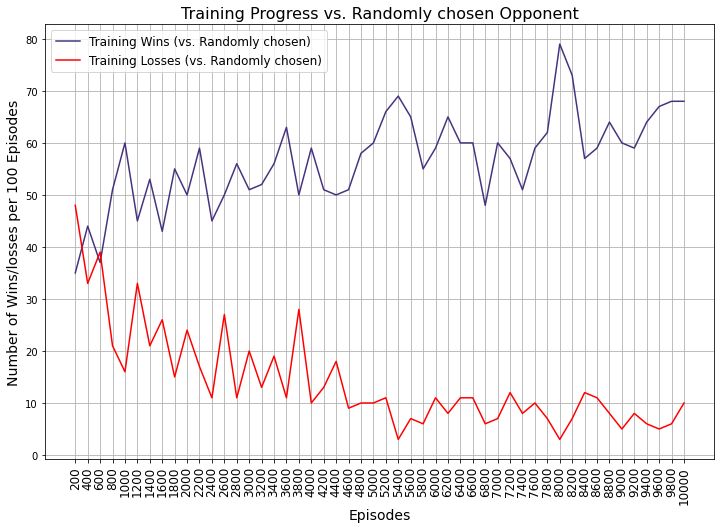

In [18]:
# TRAINING AND PLOTS - 3 

env = tic_tac_toe()
Q_agent_3 = Q_learning_agent()
safe_opponent = Safe_agent()
random_opponent = Random_agent()
training_wins_per_100_games = []
training_losses_per_100_games = []

for episode in range(1, 10001):
    if(np.random.rand() > 0.5):
        play_an_episode(env, Q_agent_3, safe_opponent)
    else:
        play_an_episode(env, Q_agent_3, random_opponent)
    
    if episode % 200 == 0:
        n_wins, n_draws, n_losses = test_agent_random(env, Q_agent_3, safe_opponent, random_opponent , 100, True)
        training_wins_per_100_games.append(n_wins)
        training_losses_per_100_games.append(n_losses)
        
      
    
plt.figure(figsize=(12, 8))
plt.plot(range(200, 10001, 200), training_wins_per_100_games, label='Training Wins (vs. Randomly chosen)')
plt.plot(range(200, 10001, 200), training_losses_per_100_games, label='Training Losses (vs. Randomly chosen)', color='red')
custom_ticks = range(200, 10001, 200)
plt.xticks(custom_ticks, rotation='vertical', fontsize=12)  
plt.xlabel('Episodes', fontsize=14)  
plt.ylabel('Number of Wins/losses per 100 Episodes', fontsize=14)  
plt.legend(fontsize=12)  
plt.title('Training Progress vs. Randomly chosen Opponent', fontsize=16)  
plt.grid(True)


sns.set_palette("viridis") 

plt.show()

In [19]:
# TESTING - 3
print("For the Q-AGENT trained against randomly chosen opponent :- \n")
random_opponent = Random_agent()
safe_opponent = Safe_agent()


total_wins_random, total_draws_random,  total_losses_random = test_agent(env, Q_agent_3, random_opponent, 1000, True)

total_wins_safe, total_draws_safe, total_losses_safe  = test_agent(env, Q_agent_3, safe_opponent, 1000, True)


print("Results vs. Random Opponent:")
print(f"Wins: {total_wins_random}, Draws: {total_draws_random}, Losses: {total_losses_random} \n")

print("Results vs. Safe Opponent:")
print(f"Wins: {total_wins_safe}, Draws: {total_draws_safe}, Losses: {total_losses_safe}")

For the Q-AGENT trained against randomly chosen opponent :- 

Results vs. Random Opponent:
Wins: 820, Draws: 140, Losses: 40 

Results vs. Safe Opponent:
Wins: 503, Draws: 398, Losses: 99


### (4) Among the three agents developed, which agent is best ? Why ?

Answer :
- Training against a random opponent may allow the Q-learning agent to explore various states and actions.
- Although, The random opponent does not provide a strong challenge, so the Q-learning agent might not learn optimal strategies for more complex scenarios.
- But, it will perform well against random opponents

Similarly, 
- Training against a safe opponent may force the Q-learning agent to adapt to a more strategic and cautious opponent.

While, 
- Randomly choosing opponents from both random and safe can add variability to the training process.
- May help develop a mix of strategies, adaptable

**In conclusion, The 3rd Agent(which trained against both random and safe opponents)** should be a **robust one** and is expected to perform better against any type of opponents than agents who were trained against specific types of opponents.

### 5) Is the Q-learning agent developed unbeatable against any possible opponent ? If not, suggest ways to improve the training process

Answer: No the agent is not unbeatable. 
- One way to improve is use human knowledge in the training as well. For example, putting your first move in a corner box improves the chances of winning. 
- Another way could be to increase the number of training rounds, and subsequently allow more exploration int the game space.
- Tune Hyperparameters: like $\epsilon$, $\alpha$ and $\gamma$
- Adaptive Learning Rates: like learning rate scheduling 

In [40]:
# Playing a game using any of the learned agent

# Example 1:  Using the 3rd trained agent against a random opponent
env = tic_tac_toe()
env.reset()
done = False
env.print_tic_tac_toe()
while not done:
    if env.current_player == 'X':
        row, col = Q_agent_3.choose_move(env, True)
    else:
        row, col = random_opponent.choose_move(env)
    env.act(row, col)
    # print(env.board)
    env.print_tic_tac_toe()
    done = env.is_game_over()


if env.is_winner('X'):
    print("The Trained Agent won the game !")
elif env.is_winner('O'):
    print("OOPS ! The Trained Agent lost the game. Train harder :)")
else:
    print("The match ended as a draw !")

---------
  |   |  
---------
  |   |  
---------
  |   |  
---------


---------
  |   |  
---------
  |   |  
---------
  | O |  
---------


---------
X |   |  
---------
  |   |  
---------
  | O |  
---------


---------
X |   |  
---------
  |   | O
---------
  | O |  
---------


---------
X |   | X
---------
  |   | O
---------
  | O |  
---------


---------
X |   | X
---------
  | O | O
---------
  | O |  
---------


---------
X | X | X
---------
  | O | O
---------
  | O |  
---------


The Trained Agent won the game !


In [45]:
# Example 2:  Using the 2nd trained agent against a safe opponent
env = tic_tac_toe()
env.reset()
safe_opponent = Safe_agent()
done = False
env.print_tic_tac_toe()
while not done:
    if env.current_player == 'X':
        row, col = Q_agent_2.choose_move(env, True)
    else:
        row, col = safe_opponent.choose_move(env)
    env.act(row, col)
    # print(env.board)
    env.print_tic_tac_toe()
    done = env.is_game_over()


if env.is_winner('X'):
    print("The Trained Agent won the game !")
elif env.is_winner('O'):
    print("OOPS ! The Trained Agent lost the game. Train harder :)")
else:
    print("The match ended as a draw !")


---------
  |   |  
---------
  |   |  
---------
  |   |  
---------


---------
X |   |  
---------
  |   |  
---------
  |   |  
---------


---------
X |   | O
---------
  |   |  
---------
  |   |  
---------


---------
X |   | O
---------
  |   |  
---------
  |   | X
---------


---------
X |   | O
---------
  | O |  
---------
  |   | X
---------


---------
X |   | O
---------
  | O |  
---------
X |   | X
---------


---------
X |   | O
---------
O | O |  
---------
X |   | X
---------


---------
X |   | O
---------
O | O |  
---------
X | X | X
---------


The Trained Agent won the game !


[' ', ' ', ' ']